# Master script for computing halo properties
## Zhuowen Zhang
### First created March 8, 2018

In [186]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from code.halo_shape_calc import quad_moment
from code.lightcone_query_ra_dec import query_file, read_radial_bin
from code.setup.setup import data_home_dir
import pyfits
datadir = data_home_dir()


In [187]:
#Basic units, MKS
ang2rad = np.pi/180
kpc2m = 3.086e19
eV2j = 1.602e-19
yr2sec = 3.154e7
c = 2.99e8 #m/s
h  = 6.626e-34 #in eV
e = 4.8e-10 #Coulumbs
G = 6.674*10**(-11) #MKS
M_sun = 1.99e30 #kg, mass of sun


In [188]:
from astropy.cosmology import FlatLambdaCDM #as cosmo 
from astropy.coordinates import SkyCoord
from astropy import units as u
import pickle
import healpy as hp
from code.setup.setup import code_home_dir
codedir = code_home_dir()

#Define cosmology
#This cosmology produces comoving distances much larger than DeRose's
h = 0.7
cosmo = FlatLambdaCDM(H0=h*100, Om0=0.3, Tcmb0=2.725) 


#First read off halo .dat file generated by Galaxy_Clusters. Retrieve and derive properties -- from RA, DEC 
#to x,y,z and comoving distance from cosmology

#Read properties of redMapper matched halos
halo_file = datadir + 'Halo_redM_matched.dat'
redM_lmda, halos_ID, halos_RA, halos_DEC, halos_z, halos_X, halos_Y, halos_Z, halos_M, halos_Rvir \
        = np.loadtxt(halo_file, dtype ="f, i, f, f, f, f, f, f, f, f", \
                     unpack=True, usecols=range(4,14), skiprows=1)

#halos_Rvir /= 1000 #Convert from Kpc to Mpc
z_cut = np.where(halos_z <= 0.34) #Joe DeRose simulation only goes to z < 0.34
redM_lmda = redM_lmda[z_cut]
halos_ID = halos_ID[z_cut]; halos_RA = halos_RA[z_cut]; halos_DEC = halos_DEC[z_cut]
halos_z = halos_z[z_cut]; halos_M = halos_M[z_cut]; halos_Rvir = halos_Rvir[z_cut];
halos_X = halos_X[z_cut]; halos_Y = halos_Y[z_cut]; halos_Z = halos_Z[z_cut]

#Use DEC, RA before rotation. They correspond to to the DEC, RA matching PX, PY, PZ 
halos_coord = np.array([halos_X, halos_Y, halos_Z])
theta, phi = np.asarray(hp.vec2ang(halos_coord.T))
halos_DEC = (np.pi/2 - theta) * 180/np.pi
halos_RA = phi * 180/np.pi
halos_num = len(halos_ID)
halos_comv = np.sqrt(halos_X**2. + halos_Y**2. + halos_Z**2.)


#Convert RA, DEC to x,y,z coordinates and z to comoving distance Using Astropy.coord package
#halos_comv_test = cosmo.comoving_distance(halos_z).value*h
#halos_coord = SkyCoord(ra=90*u.degree, dec=0*u.degree, distance=halos_comv*u.Mpc, frame='icrs')
#halos_coord = SkyCoord(ra=halos_RA*u.degree, dec=halos_DEC*u.degree, distance=halos_comv*u.Mpc, frame='icrs')
#halos_coord.representation = 'cartesian'

#Converting astopy coordinates to number array
#halos_coord_x = halos_coord.x.value
#halos_coord_y = halos_coord.y.value
#halos_coord_z = halos_coord.z.value
#halos_coord = np.array([halos_coord_x, halos_coord_y, halos_coord_z])
#print halos_ID[210], halos_RA[210], halos_DEC[210], halos_z[210]

In [4]:
#Test 
halos_shape = np.zeros(halos_num, dtype={'names':('halos_ID', 'richness', 'axes_len', 'axes_dir', 'converge'),
                          'formats':('i', 'f', '(3,)f', '(3,3)f', 'i')})
halos_shape['halos_ID'] = halos_ID
halos_shape['richness'] = redM_lmda
halos_shape['axes_len'] = np.full(3,-1)
halos_shape['axes_len'][1] = np.full(3,2.0)
print halos_shape['axes_len'][2][2]

-1.0


/home/zzbenjamin94/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(3, -1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [190]:
#Extract halo shape for each identified halo
from code.Heidi_read_halo_particles import read_halo_ptcl
from code.halo_shape_calc import quad_moment

halos_shape = np.zeros(halos_num, dtype={'names':('halos_ID', 'richness', 'Mvir', 'Rvir', 'redshift',\
            'axes_len', 'axes_dir', 'halos_dir', 'halos_RA', 'halos_DEC', 'converge'),\
            'formats':('i', 'f', 'f','f','f','(3,)f','(3,3)f','(3,)f', 'f', 'f', 'i')})
halos_shape['halos_ID'] = halos_ID
halos_shape['richness'] = redM_lmda
halos_shape['halos_dir'] = halos_coord.T
halos_shape['Mvir'] = halos_M
halos_shape['Rvir'] = halos_Rvir
halos_shape['redshift'] = halos_z
halos_shape['halos_RA'] = halos_RA
halos_shape['halos_DEC'] = halos_DEC

print "After cutoff total number of halos is ", halos_num

#Test case. Uncomment and comment part to make this run for all halos
ra_cen = 64.3599024
dec_cen = 16.68787569
red_cen = 0.23191588
x_cen = 273.26001
y_cen = 569.31482
z_cen = 189.31299
Rvir = 2.549908

for i in range(halos_num):  
    ptcl_x, ptcl_y, ptcl_z = read_halo_ptcl(ra_cen, dec_cen, red_cen,\
                            x_cen, y_cen, z_cen, Rvir)
    
    #ptcl_x, ptcl_y, ptcl_z = read_halo_ptcl(halos_RA[i], halos_DEC[i], halos_z[i],\
    #                        halos_coord[0,i], halos_coord[1,i], halos_coord[2,i], halos_Rvir[i])
    ptcl_coord = [ptcl_x, ptcl_y, ptcl_z]
    ptcl_num = len(ptcl_x)
    ptcl_cut = 100
    if i%100. == 0: print "For halo num %i number of particles inside halo is %i"%(i,ptcl_num)
    
    #Only measure shape for halos with sufficiently large halo particles
    if ptcl_num > ptcl_cut:
        #Read Shape from particles
        converge, axes_len, axes_dir = quad_moment(ptcl_coord, halos_coord[:,i], halos_Rvir[i])
    
        #Store into record array
        halos_shape['axes_len'][i] = axes_len #order of major, intermediate, minor
        halos_shape['axes_dir'][i] = axes_dir #order of minor, intermediate, major    
        halos_shape['converge'][i] = converge
    else:
        halos_shape['axes_len'][i] =  np.full(3,-1)#order of major, intermediate, minor
        halos_shape['axes_dir'][i] = np.full((3,3),-1) #order of minor, intermediate, major    
        halos_shape['converge'][i] = False 

After cutoff total number of halos is  1950
For halo num 0 number of particles inside halo is 45953


code/halo_shape_calc.py:50: RuntimeWarning: invalid value encountered in divide
  #print "Number of particles inside virial radius is ", num_mem_ptcl
code/halo_shape_calc.py:87: RuntimeWarning: invalid value encountered in divide
  P_axis = np.matrix([lx,ly,lz])


For halo num 100 number of particles inside halo is 45953
For halo num 200 number of particles inside halo is 45953
For halo num 300 number of particles inside halo is 45953
For halo num 400 number of particles inside halo is 45953
For halo num 500 number of particles inside halo is 45953
For halo num 600 number of particles inside halo is 45953
For halo num 700 number of particles inside halo is 45953
For halo num 800 number of particles inside halo is 45953
For halo num 900 number of particles inside halo is 45953
For halo num 1000 number of particles inside halo is 45953
For halo num 1100 number of particles inside halo is 45953
For halo num 1200 number of particles inside halo is 45953
For halo num 1300 number of particles inside halo is 45953
For halo num 1400 number of particles inside halo is 45953
For halo num 1500 number of particles inside halo is 45953
For halo num 1600 number of particles inside halo is 45953
For halo num 1700 number of particles inside halo is 45953
For ha

## Creating File from Data

In [110]:
#halos_shape = np.zeros(halos_num, dtype={'names':('halos_ID', 'richness', 'axes_len', 'axes_dir', 'converge'),
#                          'formats':('i', 'f', '(3,)f', '(3,3)f', 'i')})

#Doesn't have to be a FITS file. Can be a binary data file. 
#col1 = pyfits.Column(name='halos', format='20A', array=a1)
#col2 = pyfits.Column(name='V_mag', format='E', array=a2)
#halos_shape_format = ['i', 'D', '(3,)D', '(3,3)D', 'i']
#for i in range(np.shape(halos_shape)[0]):
#    cur_name = halos_shape.names[i]
#    col = pyfits.Column(name=cur_name, format=)

np.save('test.npy',halos_shape)
#np.save('test.npy', halos_shape)
#x = np.load('test.npy')
x = np.load('test.npy')
print x['halos_ID']

#print x.names
#name_str = ('halos_ID', 'richness', 'axes_len', 'axes_dir', 'converge')
#outfile = open('halos_shape.dat','w')
#outfile.write('%12s %12s %12s %12s %12s \n' %name_str)
#print halos_shape['axes_len']

#for i in range(halos_num):
#    outfile.write('%12i %12g %(3,)f %(3,3)f %12i \n' \
#                  %(halos_shape['halos_ID'][i],halos_shape['richness'][i],halos_shape['axes_len'][i],\
#                    halos_shape['axes_dir'][i],halos_shape['converge'][i]))
    
#outfile.close()


[ 7991458 18496872 10425061 ...,  9388637 10405655  7634272]


## Plotting Histogram using Extracted Data


Positions not converge: (array([ 210,  581,  626,  845, 1056, 1090, 1093, 1156, 1386, 1480, 1485,
       1527, 1559, 1658, 1669]),)
After cut positions not converged: (array([], dtype=int64),)
Number of halos after cuts is  1935
Maximum richness after cuts is  135.407


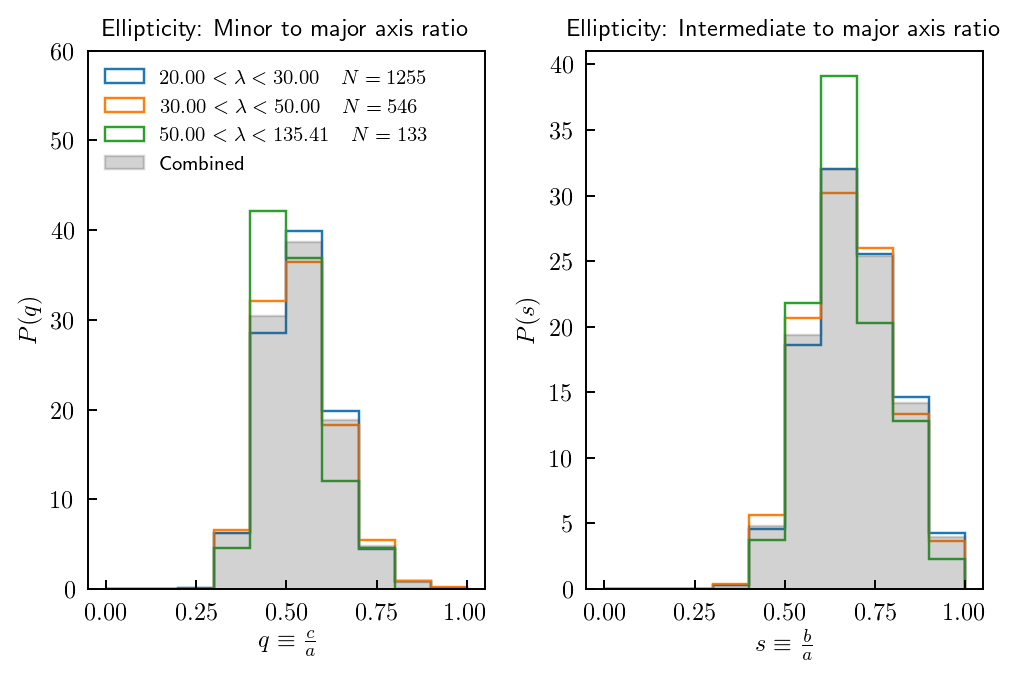

In [375]:
#!!Bug in plotting. Density makes area under plot 1, does not compute percentage. Create your own
#routine to computer actual probability. Same for plots in cells below. 

#From halos_shape.npy
halos_shape = np.load(datadir+'halos_shape.npy')

#check properties of halos with shapes not converged
ind_not_conv = np.where(halos_shape['converge'] == False)
#print 'Redshift of unconverged halos are', halos_shape[ind_not_conv]['redshift']
#print 'Mass of unconverged halos are', halos_shape[ind_not_conv]['Mvir']

print 'Positions not converge:', np.where(halos_shape['converge'] != 1)
conv_cut = np.where(halos_shape['converge']==True)
halos_shape = halos_shape[conv_cut]
halos_num = len(halos_shape)
print 'After cut positions not converged:', np.where(halos_shape['converge'] != 1)
print 'Number of halos after cuts is ', halos_num

richness = halos_shape['richness']
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
print 'Maximum richness after cuts is ', lmda_max

#Bin halos_shape by richness bins
lmda_bins_ind = []
for i, lmda_bin in enumerate(lmda_bins):
    #print i, lmda_bin
    lmda_bin_min = lmda_bin[0]; lmda_bin_max = lmda_bin[1]
    lmda_pos = np.where((richness >= lmda_bin_min) & (richness < lmda_bin_max))
    lmda_bins_ind.append(lmda_pos)

#Relevant quantities to extract and plot

axes_len = halos_shape['axes_len']
axes_dir = halos_shape['axes_dir']
q = axes_len[:,2]/axes_len[:,0]
s = axes_len[:,1]/axes_len[:,0]

#Plotting by richness bins
fig, axs = plt.subplots(1, 2, tight_layout=True)
num_bin=13; bins = np.linspace(0,1,11)
for i, lmda_bin_ind in enumerate(lmda_bins_ind):
    lmda_bin_num = len(lmda_bin_ind[0])
    lmda_bin_min = lmda_bins[i][0]; lmda_bin_max = lmda_bins[i][1]
    
    #Convert to probability in each bin
    weights = np.ones_like(q[lmda_bin_ind], dtype=float)/lmda_bin_num * 100
    #print weights
    axs[0].hist(q[lmda_bin_ind], bins, density=False, fill=False, weights=weights, histtype='step', \
               label=r'${:.2f}< \lambda < {:.2f}\quad N = {:d}$'.format(lmda_bin_min, lmda_bin_max, lmda_bin_num)) 

    axs[1].hist(s[lmda_bin_ind], bins, density=False, fill=False, weights=weights, histtype='step', \
               label=r'${:.2f}< \lambda < {:.2f}\quad N = {:d}$'.format(lmda_bin_min, lmda_bin_max, lmda_bin_num)) 

#weights for total
weights = np.ones_like(q)/(len(q)) * 100
    
axs[0].set_xlabel(r'$q \equiv \frac{c}{a}$')
axs[0].set_ylabel('$P(q)$')
axs[0].set_title(r'Ellipticity: Minor to major axis ratio', fontsize=10)
axs[0].hist(q, bins, density=False, weights=weights, fill=True, histtype='step', color='0.3', \
               label='Combined', alpha=0.25) 
axs[0].set_ylim((0,60))
axs[0].legend(loc='upper left', fontsize=8, frameon=False)

axs[1].set_xlabel(r'$s \equiv \frac{b}{a}$')
axs[1].set_ylabel('$P(s)$')
axs[1].set_title(r'Ellipticity: Intermediate to major axis ratio', fontsize=10)
axs[1].hist(s, bins, density=False, weights=weights, fill=True, histtype='step', color='0.3', \
               label='Combined', alpha=0.25) 
#plt.savefig('ellipticity_032018.png')
plt.show()

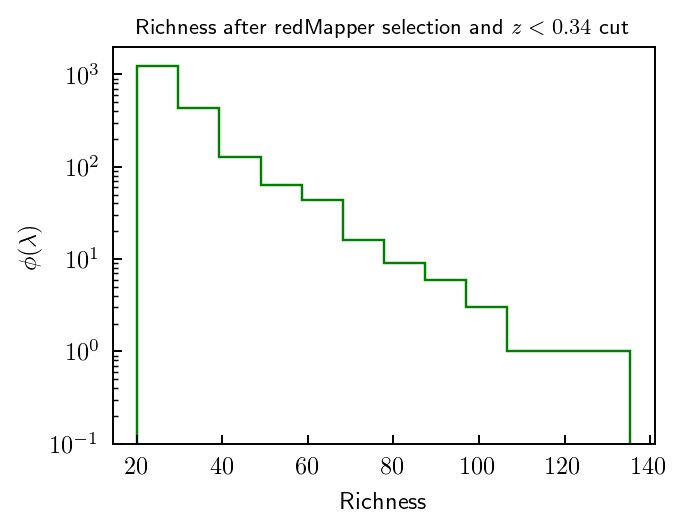

In [366]:
#Sample distribution of richness
plt.figure(figsize=(4,3))
plt.hist(richness, 12, log=True, edgecolor='g', fill=False, histtype='step')
plt.xlabel('Richness')
plt.ylabel(r'$\phi(\lambda)$')
plt.title(r'Richness after redMapper selection and $z<0.34$ cut', fontsize=9)
plt.show()
#plt.savefig('Richness_aftercuts_031918.png')

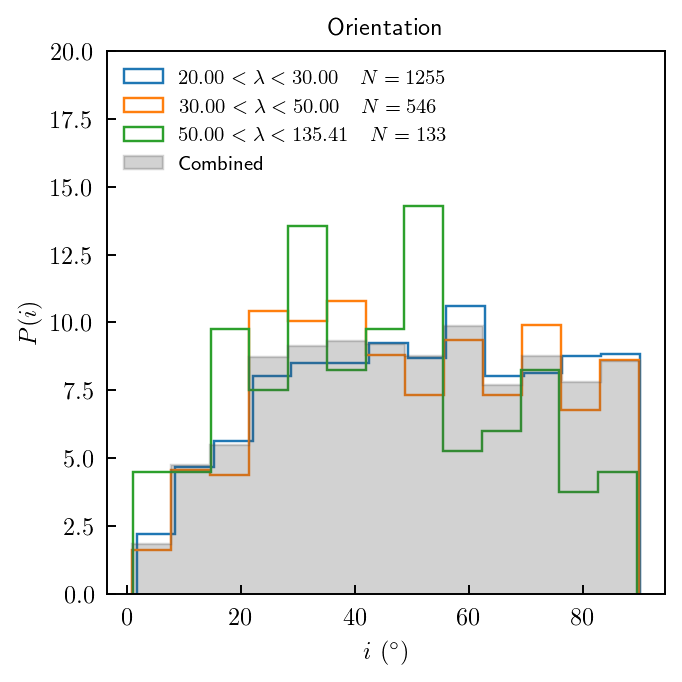

In [367]:
#Orientation PDF
halos_dir = halos_shape['halos_dir']
axes_dir = halos_shape['axes_dir']
major_dir = axes_dir[:,2,:]

#absolute value of cosine of axis between major axis and LOS
cos_i = np.zeros(halos_num) #cos(i) in lingo of Osato 2017
for i in range(halos_num):
    halos_dir_mag = np.linalg.norm(halos_dir[i])
    major_mag = np.linalg.norm(major_dir[i]);
    cos_i[i] = np.abs(np.dot(major_dir[i],halos_dir[i])/(halos_dir_mag * major_mag))
#convert cosine to angle in degrees
angle_los_halo = np.arccos(cos_i)*180/np.pi
    
#Plot histogram
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4,4))
num_bin=13
for i, lmda_bin_ind in enumerate(lmda_bins_ind):
    lmda_bin_num = len(lmda_bin_ind[0])
    
    #convert to probability of each bin
    weights = np.ones_like(angle_los_halo[lmda_bin_ind], dtype=float)/lmda_bin_num * 100
    
    lmda_bin_min = lmda_bins[i][0]; lmda_bin_max = lmda_bins[i][1]
    axs.hist(angle_los_halo[lmda_bin_ind], num_bin, density=False, fill=False, weights=weights, histtype='step', \
        label=r'${:.2f}< \lambda < {:.2f}\quad N = {:d}$'.format(lmda_bin_min, lmda_bin_max, lmda_bin_num)) 
    
#weights for total
weights = np.ones_like(angle_los_halo)/len(angle_los_halo) * 100

#plot params
axs.set_xlabel(r'$i~(^\circ)$')
axs.set_ylabel('$P(i)$')
axs.set_title(r'Orientation', fontsize=10)
axs.hist(angle_los_halo, num_bin, density=False, fill=True, weights=weights, histtype='step', color='0.3', \
         label='Combined', alpha=0.25) 
axs.legend(loc='upper left', fontsize=8, frameon=False)
axs.set_ylim((0,20))
plt.show()
#plt.savefig('orientation_pdf_032018.png')



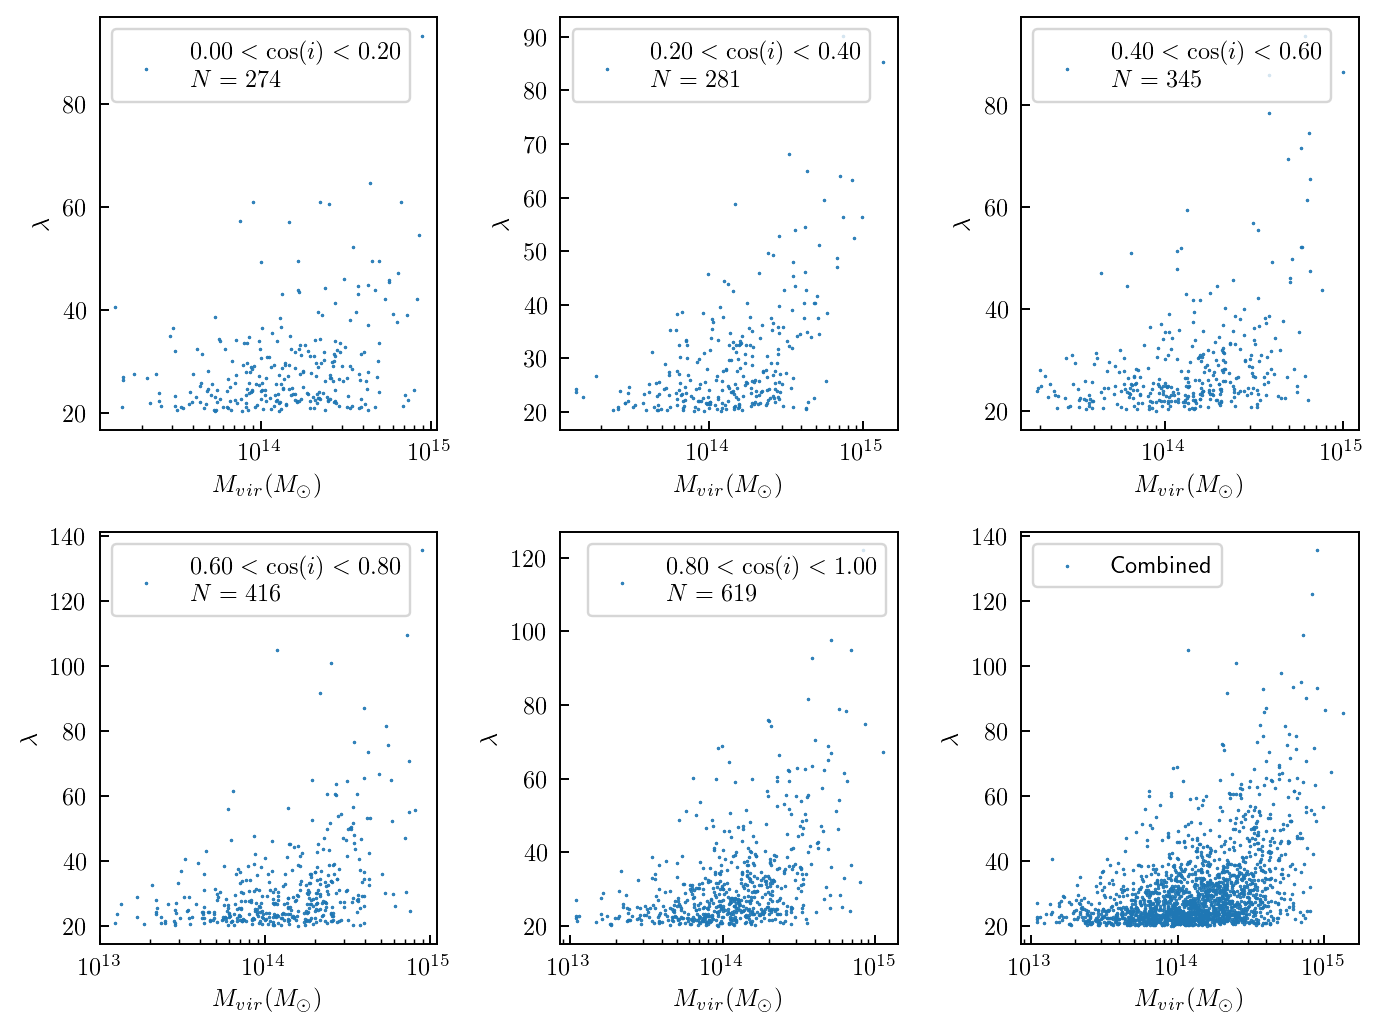

In [368]:
import math
#Mass richness relationship
halos_Mvir = halos_shape['Mvir']

#Bin by cos_i
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])

#Bin halos_shape by richness bins
cosi_bins_ind = []
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    cosi_pos = np.where((cos_i >= cosi_bin_min) & (cos_i < cosi_bin_max))
    cosi_bins_ind.append(cosi_pos)   
    
#Plotting scatter plots
fig = plt.figure(tight_layout=True, figsize=(8,6))

for i, cosi_bin_ind in enumerate(cosi_bins_ind):
    ax=fig.add_subplot(2,3,i+1)  
    cosi_bin_num = len(cosi_bin_ind[0])
    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    ax.scatter(halos_Mvir[cosi_bin_ind], richness[cosi_bin_ind], s=0.2, \
               label='${:.2f}< \cos(i) < {:.2f}$'.format(cosi_bin_min, cosi_bin_max) + '\n' +
               r'$N = {:d}$'.format(cosi_bin_num)) 
    #ax.set_title=r'${:.2f}< \cos(i) < {:.2f}$ \n $N = {:d}$'.format(cosi_bin_min, cosi_bin_max, cosi_bin_num)
    ax.set_ylabel('$\lambda$')
    ax.set_xlabel(r'$M_{vir} (M_\odot)$')
    ax.set_xscale('log')
    ax.legend()
    
ax=fig.add_subplot(2,3,6)
ax.scatter(halos_Mvir, richness, s=0.2, label=r'Combined')
ax.set_ylabel('$\lambda$')
ax.set_xlabel(r'$M_{vir} (M_\odot)$')
ax.set_xscale('log')
ax.legend()

fig.subplots_adjust(wspace=0.2, hspace=0.2,left=0.1, right=0.9, bottom=0.05, top=0.8)
plt.savefig('mass_richness_cosibinned_031918.png')
plt.show()